In [99]:
import os
import numpy as np 
import pandas as pd
from PIL import Image
import cv2
from skimage.filters import frangi
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')
dir_names=["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

In [4]:
images=[]
labels=[]

In [5]:
for dir in dir_names:
    os.chdir('./'+dir)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            label = "No_DR" if dir == "No_DR" else "DR"
            labels.append(label)
    os.chdir('../')

In [6]:
import seaborn as sns

<Axes: ylabel='count'>

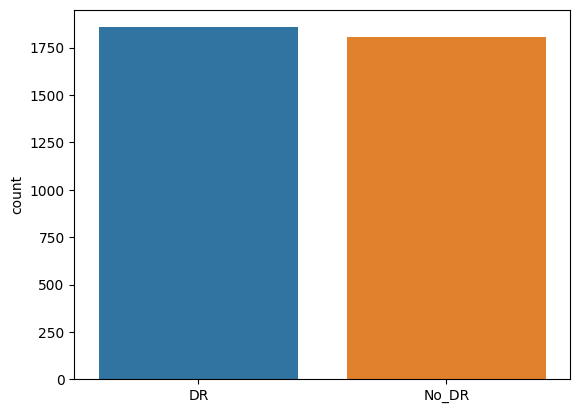

In [7]:
sns.countplot(x=labels)

In [8]:
import matplotlib.pyplot as plt

In [9]:
images = np.array(images)
labels = np.array(labels)
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

DR


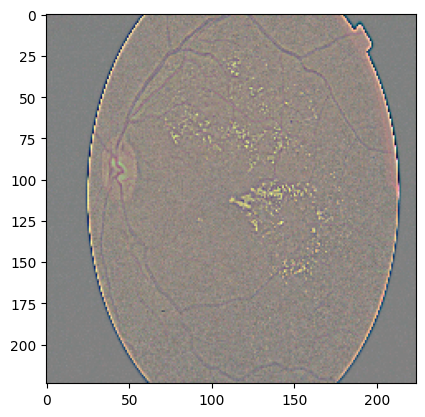

In [10]:
plt.imshow(images[55])
print(labels[0])

In [11]:
images[0].shape

(224, 224, 3)

In [12]:
def preprocessing(image, scale_range=(1, 10), scale_step=2, beta=0.5):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frangi_image = frangi(gray_image)
    frangi_image = cv2.normalize(frangi_image, None, 0, 1, cv2.NORM_MINMAX)
    return frangi_image

DR


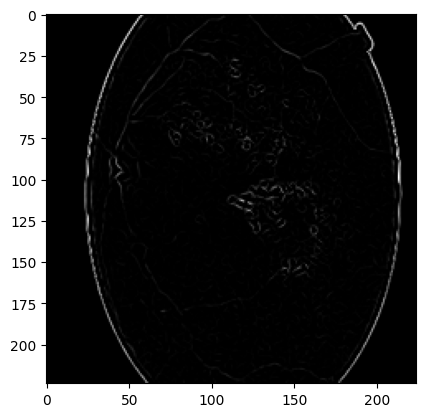

In [13]:
preprocessed_image=preprocessing(images[55])
plt.imshow(preprocessed_image,cmap='gray')
print(labels[55])

In [14]:
preprocessed_images=np.array([preprocessing(img) for img in images])

In [15]:
def threshold_image(image):
    mean_intensity = np.mean(image)
    thresholded_image = np.where(image > mean_intensity,1,0)
    return thresholded_image

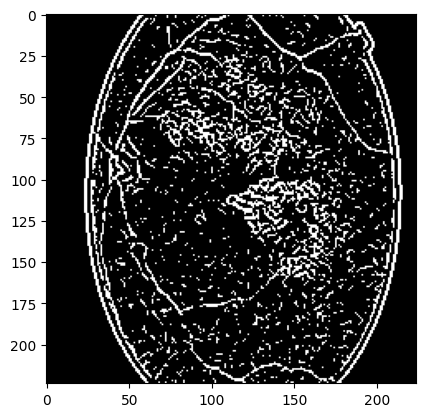

In [16]:
plt.imshow(threshold_image(preprocessed_image),cmap='gray')

In [17]:
thresholded_images=np.array([threshold_image(img) for img in preprocessed_images])

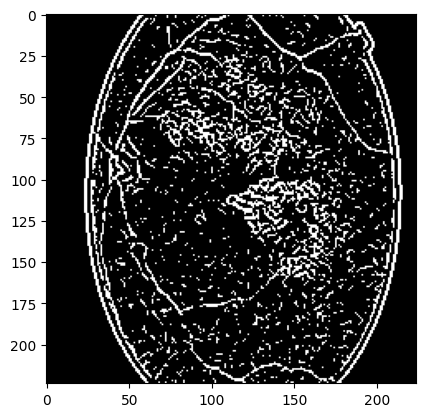

In [18]:
plt.imshow(thresholded_images[55],cmap='gray')

In [19]:
encoder=LabelEncoder()
labels=encoder.fit_transform(labels)

In [20]:
classes = encoder.classes_
print("classes:", classes)

classes: ['DR' 'No_DR']


In [21]:
x_train,x_test,y_train,y_test=train_test_split(thresholded_images,labels,test_size=.2,random_state=404,stratify=labels)

In [93]:
model = Sequential([
    Conv2D(8, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(224, 224,1), padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.5),
    Dense(84, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [95]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 108, 108, 16)   │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 21, 21, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 120)            │       768,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845,889 (3.23 MB)

 Trainable params: 845,889 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping],shuffle=True)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 693ms/step - accuracy: 0.5614 - loss: 0.6755 - val_accuracy: 0.8008 - val_loss: 0.4416
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8605 - loss: 0.3690 - val_accuracy: 0.8909 - val_loss: 0.2597
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9090 - loss: 0.2660 - val_accuracy: 0.8963 - val_loss: 0.2418
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9316 - loss: 0.2215 - val_accuracy: 0.9018 - val_loss: 0.2363
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9271 - loss: 0.2518 - val_accuracy: 0.8990 - val_loss: 0.2239
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9311 - loss: 0.2048 - val_accuracy: 0.9086 - val_loss: 0.2336
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9447 - loss: 0.1828 - val_accuracy: 0.9059 - val_loss: 0.2189
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9381 - loss: 0.1901 - val_accuracy: 0.9072 -

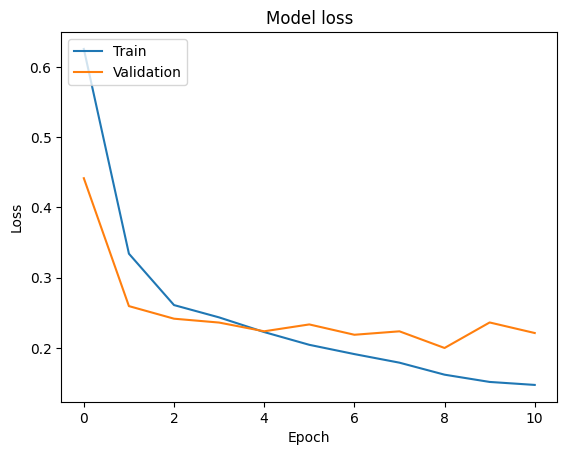

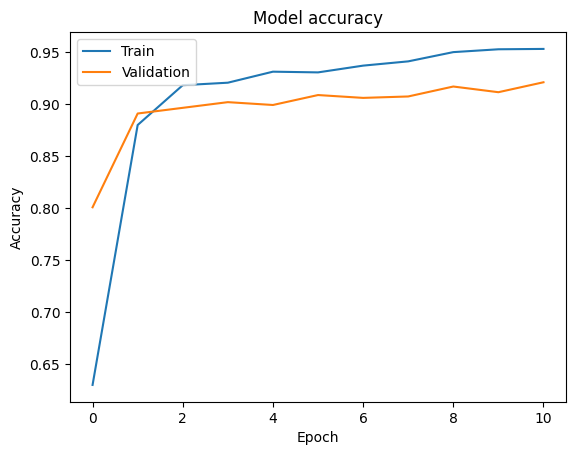

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


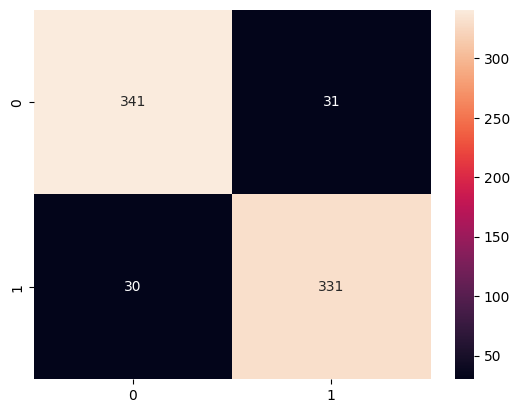

In [98]:
y_pred_probs=model.predict(x_test)
y_pred=np.where(y_pred_probs > 0.5, 1, 0)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(sns.heatmap(conf_matrix,annot=True,fmt='d'))

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       372
           1       0.91      0.92      0.92       361

    accuracy                           0.92       733
   macro avg       0.92      0.92      0.92       733
weighted avg       0.92      0.92      0.92       733



In [60]:
model.save('/kaggle/working/binary_classifier.h5')